# ECE NLP

## Overview

In this challenge you will be building a model that automatically determines logical entailment between two sentences.  
The model for this task we chose is a Bidirectionnial LSTM.

## Imports

In [2]:
import numpy as np
import pandas as pd
import csv

import tensorflow as tf
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Bidirectional, concatenate
from tensorflow.keras.optimizers import Adam

## Data import

#### Import train and test csv files

In [3]:
train_df = pd.read_csv("Data/dataset_train.csv",sep='\t', index_col='index')
test_df = pd.read_csv("Data/dataset_test_no_labels.csv",sep='\t',index_col='index')
labels = train_df['label']

In [4]:
# print(train_df.isna().sum())
# print(test_df.isna().sum())
# print(labels)

In [5]:
# train_df.values[0]

In [6]:
# print(train_df['sentence_1'].values)

## Data Transformation

In [7]:
max_sequence_length = 300
max_vocabulary_size=1000
nb_examples = len(labels)
train_size = int(0.8 * nb_examples)

### Gathering all the words

In [8]:
sentence_1 = train_df['sentence_1'].values
sentence_1_words = [line.split() for line in sentence_1]
assert( len(sentence_1_words) == len(sentence_1))

sentence_2 = train_df['sentence_2'].values
sentence_2_words = [line.split() for line in sentence_2]
assert( len(sentence_2_words) == len(sentence_2))

In [9]:
flat_sentence_1_words = [item for sublist in sentence_1_words for item in sublist]
flat_sentence_2_words = [item for sublist in sentence_2_words for item in sublist]
flat_words = flat_sentence_1_words + flat_sentence_2_words
assert(len(flat_words) == len(flat_sentence_1_words)+len(flat_sentence_2_words))

### Creating and fitting tokenizer

In [10]:
tokenizer = Tokenizer(num_words=max_vocabulary_size)
tokenizer.fit_on_texts(flat_words)

### Tokenization

In [11]:
sentence_1_tok = tokenizer.texts_to_sequences(train_df["sentence_1"])
sentence_2_tok = tokenizer.texts_to_sequences(train_df["sentence_2"])

In [12]:
#print(len(max(train_df["sentence_1"], key=len)),len(max(sentence_1_tok, key=len)))

### Padding

In [13]:
sentence_1_pad = sequence.pad_sequences(sentence_1_tok,maxlen=max_sequence_length, dtype='int32', truncating="post",padding="post")
sentence_2_pad = sequence.pad_sequences(sentence_2_tok,maxlen=max_sequence_length, dtype='int32', truncating="post",padding="post")

In [14]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
def sequence_to_text(sentence):
    # Looking up words in dictionary
    words = [reverse_word_map.get(word) for word in sentence]
    return(words)

# Creating texts 
totext = list(map(sequence_to_text, [sentence_1_tok[0]]))
totext

print("original : ",train_df["sentence_1"][0])
print("tokenized : ",sentence_1_tok[0])
print("de-tokenized : ",totext)
print("padded : ",sentence_1_pad[0])

original :  Conceptually cream skimming has two basic dimensions - product and geography.
tokenized :  [37, 95, 798, 4]
de-tokenized :  [['has', 'two', 'product', 'and']]
padded :  [ 37  95 798   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0

In [15]:
# Check tokenizer
# tokenizer.get_config()

### Integer encoded Labels

In [16]:
def translate_labels(labels,inverse=False):
    convert_dict = {
      'entailment': 0,
      'neutral': 1,
      'contradiction': 2
    }
    convert_dict_inverse = {
      0: 'entailment',
      1: 'neutral',
      2: 'contradiction'
    }
    new_labels=[]
    if inverse:
        new_labels.append(convert_dict_inverse[labels])
    else:
        for label in labels:
            new_labels.append(convert_dict[label])
    
    return new_labels

In [17]:
num_labels = translate_labels(labels)

## Model Definition

In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals
tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [19]:
vocabulary_size = max_vocabulary_size
BATCH_SIZE = 1024
embedding_size = 64
hidden_size = 64
epochs = 10

This next cell is useful to reset the model and to not get any errors during training

In [20]:
premise = tf.keras.Input(shape=(max_sequence_length), name='Premise')        # Sequence of ints
hypothesis = tf.keras.Input(shape=(max_sequence_length), name='Hypothesis')  # Sequence of ints

emb_1 = Embedding(vocabulary_size,embedding_size)(premise)       
emb_2 = Embedding(vocabulary_size,embedding_size)(hypothesis)

x = concatenate([emb_1, emb_2])
x = Bidirectional(tf.keras.layers.LSTM(hidden_size))(x)
x = Dense(hidden_size, activation='relu')(x)
x = Dense(3, activation='softmax')(x)

model = Model(inputs=[premise, hypothesis], outputs=x)
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Premise (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
Hypothesis (InputLayer)         [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 64)      64000       Premise[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 64)      64000       Hypothesis[0][0]                 
______________________________________________________________________________________________

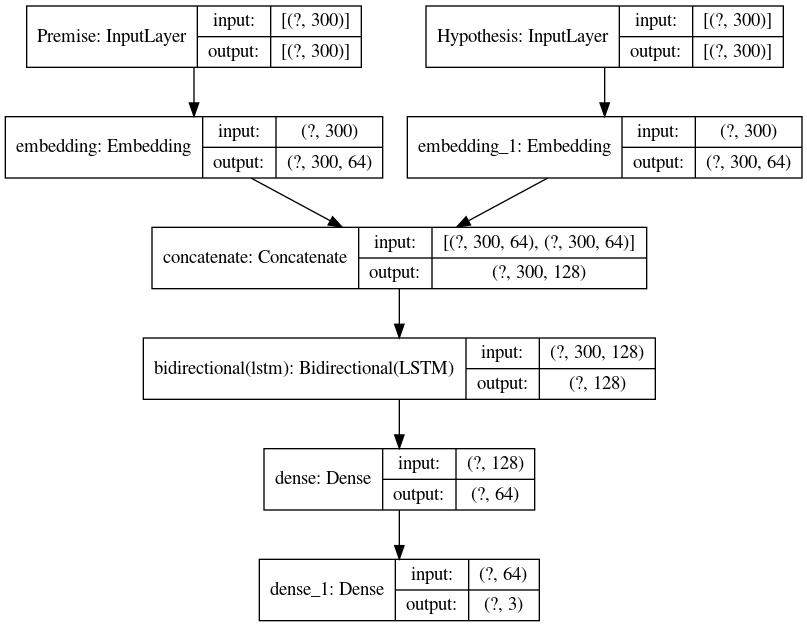

In [22]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

## Model Training/Evaluation

### Preparing dataset for training

In [23]:
def input_fn(input_1,input_2, labels, BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(({"Premise": input_1, "Hypothesis": input_2}, labels))
    dataset = dataset.batch(BATCH_SIZE).shuffle(1000)
    return dataset

In [24]:
dataset = input_fn(sentence_1_pad,sentence_2_pad, num_labels, BATCH_SIZE)
dataset

<ShuffleDataset shapes: ({Premise: (None, 300), Hypothesis: (None, 300)}, (None,)), types: ({Premise: tf.int32, Hypothesis: tf.int32}, tf.int32)>

### Splitting dataset into training/validation

In [25]:
train_dataset = dataset.take(train_size) 
val_dataset = dataset.skip(train_size)

### Training the network

In [1]:
model.fit(train_dataset, 
          steps_per_epoch= train_size // BATCH_SIZE,
          validation_data=val_dataset,
          validation_steps= ( nb_examples - train_size ) // BATCH_SIZE,
          epochs=10,verbose=1)

NameError: name 'model' is not defined

## Model Inference

In [159]:
test_sentence_1_tok = tokenizer.texts_to_sequences(test_df["sentence_1"])
test_sentence_2_tok = tokenizer.texts_to_sequences(test_df["sentence_2"])

test_sentence_1_pad = sequence.pad_sequences(test_sentence_1_tok,maxlen=max_sequence_length, dtype='int32', truncating="post",padding="post")
test_sentence_2_pad = sequence.pad_sequences(test_sentence_2_tok,maxlen=max_sequence_length, dtype='int32', truncating="post",padding="post")

In [160]:
tmp = []
tmp.append(test_sentence_1_pad)
tmp.append(test_sentence_2_pad)

X_test = np.array(tmp)

In [163]:
predict = model.predict([X_test[0],X_test[1]],verbose=True)

19647/19647 [==============================] - 58s 3ms/sample


In [194]:
pred_labels=pd.DataFrame(columns=["index","label"])

for index,pred in enumerate(predict):
    real_label = translate_labels(np.round(np.argmax(pred)),inverse=True)
    real_label = str(real_label).strip('[]').replace("'","")
    pred_labels = pred_labels.append({'index':index, 'label':real_label},ignore_index=True)

In [195]:
pred_labels

,index,label
0,0,entailment
1,1,entailment
2,2,neutral
3,3,contradiction
4,4,contradiction
...,...,...
19642,19642,contradiction
19643,19643,neutral
19644,19644,neutral
19645,19645,neutral


## Export results

In [196]:
pred_labels.to_csv('submission.csv', index = False)

In [197]:
TableBIS = pd.read_csv("submission.csv", sep="\t")
print(TableBIS)

               index,label
0             0,entailment
1             1,entailment
2                2,neutral
3          3,contradiction
4          4,contradiction
...                    ...
19642  19642,contradiction
19643        19643,neutral
19644        19644,neutral
19645        19645,neutral
19646     19646,entailment

[19647 rows x 1 columns]
